# <center>Homework 2: French to English Translation Using Sequence-to-Sequence RNNs with Attention</center>

<center>Submitted by: <b>BJ Enrik Yepes</b></center>

In this notebook, we will implement *Sean Robertson's* **"NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION"** using a Jupyter notebook. The purpose of this notebook is to deepen our understanding of the original implementation. we will provide detailed explanations for each code block or cell, aiming to address and investigate relevant questions related to the topic.

# Requirements

To begin, we will import the necessary libraries. Here's an explanation for each import:

1. `__future__` enables compatibility between Python 2 and Python 3, allowing us to use Python 3 features such as `unicode_literals`, `print_function`, and `division`.
2. The `open` function from the `io` module ensures files are opened in the correct encoding.
3. The `unicodedata` module is used to work with Unicode characters and their properties.
4. The `string` module provides various string operations.
5. The `re` module allows us to work with regular expressions (regex), used for string matching and string manipulation.
6. The `random` module allows us to generate random numbers.
7. The `pandas` module allows us to read text files returned in a pandas.DataFrame format.
8. The `torch` library is PyTorch, a deep learning framework.
9. The `torch.nn` module contains classes for defining neural networks.
10. The `optim` module from the PyTorch library provides optimization algorithms for training neural networks. 
11. The `torch.nn.functional`, imported as `F`, contains various activation functions and loss functions.

By importing these libraries, we ensure that we have the necessary tools and functions imported to implement the NLP model from scratch.

Additionally, `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` assigns a value to device based on the availability of a CUDA-enabled GPU. Having CUDA enabled makes our training significantly faster.

In [208]:
# General Imports
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Assign device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

1. Describe what **neural machine translation** is and how it is done using a **sequence-to-sequence RNN with attention.**

`Neural Machine Translation` (NMT) is an approach to automatic translation that uses `neural networks` to directly translate text from one language to another. It is a departure from traditional statistical machine translation methods that relied on predefined linguistic rules and handcrafted features.

In NMT, a popular architecture for achieving translation is the `sequence-to-sequence` (Seq2Seq) model with an `attention` mechanism. This model consists of two `recurrent neural networks` (RNNs) known as the `encoder` and `decoder`. Here's a high-level overview of how NMT with Seq2Seq and attention works:

- **Encoder** - The input sentence in the source language is fed into the encoder RNN one word at a time. The encoder processes the sequence and produces a fixed-size representation called the context vector, which captures the meaning of the entire source sentence.

- **Attention** - At each step of the decoding process, the decoder RNN generates a target word based on the current context vector and the previously generated words. To assist the decoder in focusing on relevant parts of the source sentence, an attention mechanism is employed. The attention mechanism computes attention weights that reflect the importance of each word in the source sentence for generating the current target word.

- **Decoder** - The decoder RNN takes the attention weights and the context vector as inputs, along with the previously generated word. It generates the next target word based on this information. The decoder continues generating words one at a time until it reaches an end-of-sentence token or a maximum length.

The `encoder-decoder` mechanism is a common and fundamental mechanism used in various architectures in deep learning. The encoder-decoder mechanism allows the model to handle input sequences of varying lengths and generate corresponding output sequences. It has been successfully applied not only in neural machine translation but also in various other natural language processing tasks, such as text summarization, speech recognition, dialogue systems, image captioning, and more. However, what differentiates this architecture from other encoder-decoder-based architectures is the `attention` mechanism.

The `attention` mechanism plays a crucial role in NMT by allowing the model to focus on relevant parts of the source sentence as it generates the translation. This improves the model's ability to capture long-range dependencies and handle sentence-level semantics, leading to more accurate translations.

2. Describe the **dataset** being used in this example.

The dataset `eng-fra.txt` is a collection of English-French word pairs intended for machine translation or similar natural language processing tasks. Below is a summary of its characteristics:

- It is formatted with tab delimiters (\t)
- Encoded using UTF-8
- Contains 135,842 rows
- Contains 2 columns
- Does not include any headers

In [3]:
# Create pandas dataframe for sample data
df = pd.read_table('data/eng-fra.txt',
                   sep='\t',
                   header=None,
                   encoding='utf-8',
                   names=['English', 'French'])

# Display first five rows of dataframe
df.head(5)

,English,French
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [4]:
df.shape

(135842, 2)

# Data Preprocessing

3. Describe the **preprocessing steps** being done in preparation for training the model.

## Loading Data Files

This code defines the `Lang` class, which provides methods to process language data. It allows the addition of sentences (`addSentence`) and words (`addWord`), and keeps track of word counts, indices, and mappings between words and indices. The class is useful for building language vocabularies and representing text data in a format suitable for training language models or other natural language processing tasks.

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    Class representing a language with vocabulary and word-to-index mappings.
    """
    def __init__(self, name):
        """
        Initialize a new language.

        Args:
            name (str): The name of the language.
        """
        self.name = name
        self.word2index = {} # Maps words to their indices
        self.word2count = {} # Keeps count of each word
        self.index2word = {0: "SOS", 1: "EOS"} # Maps indices to words
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        """
        Add a sentence to the language vocabulary.

        Args:
            sentence (str): The sentence to add.
        """
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """
        Add a word to the language vocabulary.

        Args:
            word (str): The word to add.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

This code block provides two functions: (1) `unicodeToAscii` and (2) `normalizeString`.

The `unocodetoAscii`function converts a Unicode string to plain ASCII by iterating over the characters in the string and applying two operations:
1. `unicodedata.normalize` - Normalizes the string `s` using Unicode normalization form NFD that decomposes accented characters into their base character and combines diacritical marks.
2. `unicodedata.category` -  filters out characters that are categorized as non-spacing marks "Mn". It removes the diacritical marks and other non-spacing characters from the string.
3. `.join`- the resulting characters are joined together using to form the final ASCII string.

The `normalizeString` function performs further normalization and cleaning operations on the input string s. It applies the following transformations:
1. `s.lower().strip()` - converts the string to lowercase and removes leading and trailing whitespaces.
2. `re.sub(r"([.!?])", r" \1", s)`- adds a space before punctuation marks (.!?). It ensures that punctuation marks are separated from words by whitespace, making them easier to tokenize later.
3. `re.sub(r"[^a-zA-Z.!?]+", r" ", s)` - replaces any non-letter characters (excluding .!?) with a single whitespace. It removes any characters that are not letters or punctuation marks, ensuring that the string only contains valid tokens.

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Convert a Unicode string to its ASCII representation.

    Args:
        s (str): The input string.

    Returns:
        str: The ASCII representation of the input string.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    """
    Normalize a string by converting it to lowercase, removing diacritics,
    adding spaces around punctuation, and removing non-alphabetic characters.

    Args:
        s (str): The input string.

    Returns:
        str: The normalized string.
    """
    # Convert to lowercase and remove diacritics
    s = unicodeToAscii(s.lower().strip()) 
    s = re.sub(r"([.!?])", r" \1", s) # Add spaces around punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # Remove non-alphabetic characters
    return s

This code defines a function named `readLangs` that reads and processes language pairs from a file.

Under the hood, this code reads language pairs from a file, splits the lines, normalizes the strings in each pair, and optionally reverses the order of the pairs based on the `reverse` flag. It also creates `Lang` objects to represent the input and output languages. The function returns the input language, output language, and pairs as its output.

In [7]:
def readLangs(lang1, lang2, reverse=False):
    """
    Read language pairs from a text file, split them into pairs, and create
    language instances.

    Args:
        lang1 (str): The language code for the first language.
        lang2 (str): The language code for the second language.
        reverse (bool, optional): Flag indicating whether to reverse
                                  the language pairs. Defaults to False.

    Returns:
        tuple: A tuple containing the input language instance, output
               language instance, and a list of language pairs.
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

This code defines two functions: filterPair and filterPairs, which are used to filter language pairs based on certain conditions. Here's a breakdown of what each function does:

1. `filterPair` - used to apply filtering conditions to an individual language pair, such as length limitations and prefix matching.
2. `filterPairs` - applies the `filterPair` function to a list of language pairs to filter out pairs that do not satisfy the conditions. 

Also, considering that we have a large number of example sentences and aim to expedite the training process, we will reduce the dataset to include only relatively short and straightforward sentences. Specifically, we will set a maximum length of 10 words, taking into account the ending punctuation. Additionally, we will filter the sentences to include only those that translate to the form "I am," "He is," and so on, considering the apostrophes that have been replaced earlier.

In [8]:
# Maximum length of a sentence
MAX_LENGTH = 10

# Prefixes
eng_prefixes = (
    "i am ", "i m ", 
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    """
    Filter a language pair based on length and English prefix.

    Args:
        p (list): A pair of sentences.

    Returns:
        bool: True if the pair satisfies the filter conditions,
        False otherwise.
    """
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    """
    Filter a list of language pairs based on length and English prefix.

    Args:
        pairs (list): A list of language pairs.

    Returns:
        list: The filtered list of language pairs.
    """
    return [pair for pair in pairs if filterPair(pair)]

This code defines a function named `prepareData` that prepares the language data for training by reading, filtering, and counting words in the pairs of sentences. It returns the input and output language objects and the filtered pairs.

Then the last part of the code calls the `prepareData` function and selects a random pair from the filtered pairs to print as an example.

In [9]:
def prepareData(lang1, lang2, reverse=False):
    """
    Prepare the data for training a translation model.

    Args:
        lang1 (str): Language code for the source language.
        lang2 (str): Language code for the target language.
        reverse (bool, optional): Flag to reverse the source-target pairs.
        Defaults to False.

    Returns:
        input_lang (Lang): Input language object.
        output_lang (Lang): Output language object.
        pairs (list): List of sentence pairs.

    """
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Prepare data for English to French translation
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

print(random.choice(pairs)) # Print a random sentence pair

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis le capitaine .', 'i m the captain .']


# The Seq2Seq Model

After the preprocessing steps, we need to create our `Seq2Seq` network that is composed of two `RNNs` called the `encoder` and `decoder` that will read the input sequence, output a single vector, reads that vector, and produces an output sequence. We will also put an `attention` mechanism to focus only on relevant parts of the source sentence as it generates the translation. This improves the model's ability to capture long-range dependencies and handle sentence-level semantics, leading to more accurate translations.

## The Encoder

This code defines a class called EncoderRNN which represents the encoder component of a recurrent neural network (RNN) used in sequence-to-sequence models. It takes an input tensor, applies embedding and GRU layers to the input, and produces the output tensor and the updated hidden state tensor. The class also provides a method to initialize the hidden state tensor.

In [10]:
class EncoderRNN(nn.Module):
    """
    Encoder RNN module for sequence encoding.

    Args:
        input_size (int): Size of the input vocabulary.
        hidden_size (int): Size of the hidden state.

    """
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """
        Forward pass of the encoder.

        Args:
            input (tensor): Input tensor of shape (sequence_length).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).

        Returns:
            output (tensor): Output tensor of shape (1, 1, hidden_size).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).

        """
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        """
        Initialize the hidden state tensor.

        Returns:
            hidden (tensor): Initialized hidden state tensor of shape (1, 1, hidden_size).

        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder

The next two code blocks define two classes namely: `DecoderRNN` and `AttnDecoderRNN` which represent the decoder component of our `Seq2Seq` model. One without an attention mechanism, and the other with an attention mechanism. We will use both of these classes to compare and contrast the `DecoderRNN` and `AttnDecoderRNN` models in terms of loss, training time, parameter count, and quality of translation.

### Simple Decoder

The `DecoderRNN` class encapsulates the functionality of the decoder in a sequence-to-sequence model. It takes an input sequence, processes it through various layers, and produces the predicted output sequence. Take note, this is the decoder implementation without an attention mechanism.

In [11]:
class DecoderRNN(nn.Module):
    """
    Decoder RNN module for sequence decoding.

    Args:
        hidden_size (int): Size of the hidden state.
        output_size (int): Size of the output vocabulary.

    """
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        """
        Forward pass of the decoder.

        Args:
            input (tensor): Input tensor of shape (1).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).

        Returns:
            output (tensor): Output tensor of shape (1, output_size).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).

        """
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        """
        Initialize the hidden state tensor.

        Returns:
            hidden (tensor): Initialized hidden state tensor of
            shape (1, 1, hidden_size).

        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder

The `AttnDecoderRNN` class on the other hand represents the attention-based decoder in a sequence-to-sequence model. It takes an input sequence, processes it through various layers while incorporating `attention`, and produces the predicted output sequence. The attention mechanism allows the decoder to selectively focus on different parts of the input sequence, enhancing the translation performance.

In [12]:
class AttnDecoderRNN(nn.Module):
    """
    Attention-based Decoder RNN module for sequence decoding.

    Args:
        hidden_size (int): Size of the hidden state.
        output_size (int): Size of the output vocabulary.
        dropout_p (float): Dropout probability for regularization. Default: 0.1
        max_length (int): Maximum length of input sequence. Default: MAX_LENGTH

    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        """
        Forward pass of the attention-based decoder.

        Args:
            input (tensor): Input tensor of shape (1).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).
            encoder_outputs (tensor): Encoder outputs tensor
            of shape (max_length, hidden_size).

        Returns:
            output (tensor): Output tensor of shape (1, output_size).
            hidden (tensor): Hidden state tensor of shape (1, 1, hidden_size).
            attn_weights (tensor): Attention weights tensor
            of shape (1, max_length).

        """
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        """
        Initialize the hidden state tensor.

        Returns:
            hidden (tensor): Initialized hidden state tensor
            of shape (1, 1, hidden_size).

        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training

Now, we need to prepare helper functions to train our model. This involves preparing the data for training and defining the training loop that incorporates all the helper functions declared in the previous code blocks.

## Preparing Training Data

First, we need to convert sentences into tensors, which is required when working with neural network models that operate on numerical representations. We do this by defining three functions: `indexesFromSentence`, `tensorFromSentence`, and `tensorsFromPair`. Below is a brief description of what these functions are for:

1. `indexesFromSentence` - takes in an instance of the `lang` class and a sentence as an input, then splits the sentence into individual words, and for each word, it retrieves the corresponding index from the `word2index` dictionary of the `lang` object then returns a list of word indices.
2. `tensorFromSentence` - takes in an instance of the `land` class and a sentence as an input, then utilizes `indixesFromSentence` to obtain a list of word indices from a sentence, then appends the index of the End-Of-Sequence `EOS` token to mark the end of the sentence. The function then creates a PyTorch tensor from the list of indices, specifying the datatype as `torch.long`. It then reshapes the tensor to have a shape of (-1, 1), where -1 indicates that the size is inferred based on the length of the tensor.
3. `tensorsFromPair` - takes in a pair of sentences, the input and the target, as inputs then utilizes the `tensorFromSentence` to convert each sentence into a tensor, with the appropriate language object. It then returns a tuple of the input tensor and target tensor.

In [13]:
def indexesFromSentence(lang, sentence):
    """
    Convert a sentence to a list of word indexes using the language
    vocabulary.

    Args:
        lang (Lang): Language object containing vocabulary.
        sentence (str): Input sentence to be converted.

    Returns:
        indexes (list): List of word indexes.

    """
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    """
    Convert a sentence to a tensor representing the indexes of words.

    Args:
        lang (Lang): Language object containing vocabulary.
        sentence (str): Input sentence to be converted.

    Returns:
        tensor (tensor): Tensor representing the word indexes.

    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """
    Convert a pair of sentences to tensors representing the input and target.

    Args:
        pair (tuple): Pair of input and target sentences.

    Returns:
        input_tensor (tensor): Tensor representing the input sentence.
        target_tensor (tensor): Tensor representing the target sentence.

    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Training the Model

Next, we need to implement a training loop for the Seq2Seq model. Here, the `train` function takes in several input parameters, including input and target tensors, the encoder and decoder models, their respective optimizers, a criterion for calculating the loss, and the maximum length of sequences. Its purpose is to train the model on the given data.

We also introduce a new functionality called the `teacher forcing`. Teacher forcing is a technique where the true target token is fed as input to the decoder at each time step, instead of using its own predictions. Here, the decision whether to use teacher forcing or not is determined probabilistically using the `teacher_forcing_ratio`.

This training function plays a crucial role in training the encoder-decoder model by iteratively updating its parameters to minimize the loss between predicted and target tokens. Through this training process, the model learns to generate meaningful sequences and can be later used for tasks such as machine translation or text summarization.

Basically, the `train` function is the `inner loop` that performs a single training iteration for a given input and target tensor. We still need another helper function that will act as the `outer loop` that iterates over a specified number of training iterations that calls the `train` function within each iteration.

In [14]:
# Teacher Forcing Ratio
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Perform a single training step on the given input and target tensors.

    Args:
        input_tensor (tensor): Tensor representing the input sentence.
        target_tensor (tensor): Tensor representing the target sentence.
        encoder (EncoderRNN): Encoder model.
        decoder (DecoderRNN or AttnDecoderRNN): Decoder model.
        encoder_optimizer (torch.optim.Optimizer): Optimizer for encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizer for decoder.
        criterion: Loss criterion.
        max_length (int): Maximum length of input sequences (default: MAX_LENGTH).

    Returns:
        loss.item() / target_length (float): Normalized loss value.

    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Encoding phase
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            
            elif type(decoder).__name__ == 'DecoderRNN':
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            
            elif type(decoder).__name__ == 'DecoderRNN':
                decoder_output, decoder_hidden, = decoder(
                    decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Since we are also interested in tracking our progress with the elapsed time and estimated remaining time, we introduce two new helper functions that will help us with that functionality.

1. `asMinutes` - Converts a time duration in seconds to a human-readable format in minutes and seconds.
2. `timeSince` - Calculates the elapsed time and estimated remaining time for a process based on the starting time and progress percentage.

In [15]:
# Additional Imports
import time
import math

def asMinutes(s):
    """
    Convert seconds to minutes and seconds in the format 'm:ss'.

    Args:
        s (int): Number of seconds.

    Returns:
        str: Time in minutes and seconds format.

    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """
    Calculate the elapsed time and estimated remaining time.

    Args:
        since (float): Starting time in seconds.
        percent (float): Percentage of completion.

    Returns:
        str: Elapsed time and estimated remaining time in minutes
        and seconds format.

    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

We now introduced what we called earlier the `outer loop` that iterates over a specified number of training iterations and calls the `train` function within each iteration. We then call this function `trainIters`

This function manages the overall training process, tracks the loss, and handles the printing and plotting of results.

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """
    Train the encoder-decoder model for a specified number of iterations.

    Args:
        encoder (EncoderRNN): Encoder model.
        decoder (DecoderRNN or AttnDecoderRNN): Decoder model.
        n_iters (int): Number of training iterations.
        print_every (int): Print the average loss every `print_every` iterations. Default: 1000.
        plot_every (int): Plot the average loss every `plot_every` iterations. Default: 100.
        learning_rate (float): Learning rate for the optimizer. Default: 0.01.

    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting Results

4. Describe the **postprocessing code/functions** that have been created for performing inference and analyzing the model weights.

The first helper function that we define in the postprocessing steps is the `showPlot` function. This function is used in the training loop and should therefore be defined to utilize its functionality. It uses Matplotlib to create a line plot of the given points. It creates a new figure, sets the y-axis tick intervals, and plots the points.

In [17]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    """
    Plot the points on a graph.

    Args:
        points (list): List of points to be plotted.

    """
    
    plt.figure()
    fig, ax = plt.subplots()
    
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8v5viky2 because the default path (/home/byepes/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Evaluation

The second helper function that we define is the `evaluate` function. This function evaluates a given input sentence using the trained encoder and decoder models. It takes the encoder, decoder, and the input sentence as inputs.

Under the hood, it processes the input sentence by encoding it using the encoder and then decoding it using the decoder. The function returns the decoded words and the decoder attentions, which indicates the importance of input words at each step of decoding.

In [144]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Evaluate a given sentence using the encoder and decoder models.

    Args:
        encoder (EncoderRNN): Encoder model.
        decoder (DecoderRNN or AttnDecoderRNN): Decoder model.
        sentence (str): Input sentence to evaluate.
        max_length (int, optional): Maximum length of output sentence.
        Defaults to MAX_LENGTH.

    Returns:
        tuple: A tuple containing the decoded words (list) and decoder
        attentions (tensor).

    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data

            elif type(decoder).__name__ == 'DecoderRNN':
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        if type(decoder).__name__ == 'AttnDecoderRNN':
            return decoded_words, decoder_attentions[:di + 1]
        
        elif type(decoder).__name__ == 'DecoderRNN':
            return decoded_words, None

Third, we define a helper function `evalateRandomly` that randomly selects pairs of input sentences from the dataset and evaluates them using the trained encoder and decoder models.

It prints the input sentence, the expected output sentence, and the generated output sentence. The function is useful for visually inspecting the model's performance on random examples from the dataset.

In [145]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evaluate randomly chosen sentences using the encoder and decoder models.

    Args:
        encoder (EncoderRNN): Encoder model.
        decoder (DecoderRNN or AttnDecoderRNN): Decoder model.
        n (int, optional): Number of sentences to evaluate. Defaults to 10.

    Returns:
        tuple: A tuple containing the references (list) and candidates (list) for evaluation.

    """
    import re
    references = [] # List to store reference sentences
    candidates = [] # List to store generated sentences
    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        # Evaluate the input sentence
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        references.append([pair[1]]) # Add the reference sentence to the list
        
        # Add the generated sentence to the list (remove <EOS> token)
        candidates.append(output_sentence.split(' <', 1)[0])
    return references, candidates

## Training and Evaluating

5. Compare and contrast the DecoderRNN and AttnDecoderRNN models in terms of loss, training time, parameter count, and quality of translation.

### AttnDecoderRNN vs DecoderRNN using GRU

#### Comparison of Loss and Training Time

With all the helper functions in place, we can now perform training and evaluation. Let's quickly break down the content of this code block:

1. Sets the size of the hidden layer to 256
2. Creates an instance of the `EncoderRNN` class called `encoder1` with the specified input size and hidden size. 
3. Creates an instance of the `AttnDecoderRNN` class called `attn_decoder1` with the specified hidden size and output size.
4. Calls the `trainIters` function to train the `encoder1` and `attn_decoder1` models for 75,000 iterations, with the training progress being printed every 5000 iterations.

2m 57s (- 41m 19s) (5000 6%) 2.8238
5m 47s (- 37m 36s) (10000 13%) 2.2877
8m 30s (- 34m 2s) (15000 20%) 1.9744
11m 23s (- 31m 19s) (20000 26%) 1.7430
14m 9s (- 28m 19s) (25000 33%) 1.5336
16m 56s (- 25m 24s) (30000 40%) 1.3788
19m 41s (- 22m 29s) (35000 46%) 1.2199
22m 27s (- 19m 38s) (40000 53%) 1.0990
25m 22s (- 16m 55s) (45000 60%) 0.9807
28m 0s (- 14m 0s) (50000 66%) 0.9103
30m 50s (- 11m 12s) (55000 73%) 0.8386
33m 42s (- 8m 25s) (60000 80%) 0.7282
36m 33s (- 5m 37s) (65000 86%) 0.6981
39m 13s (- 2m 48s) (70000 93%) 0.6349
42m 5s (- 0m 0s) (75000 100%) 0.5614


<Figure size 640x480 with 0 Axes>

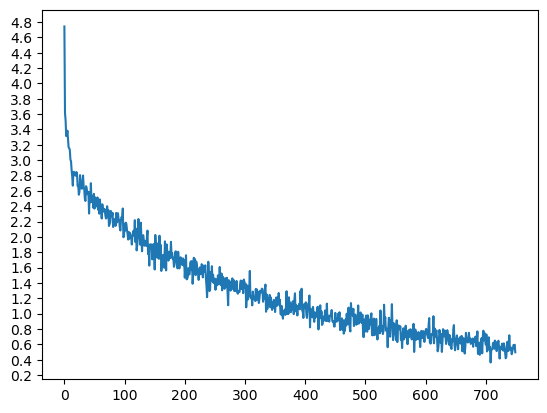

In [22]:
hidden_size = 256

# Initialize the encoder and decoder models
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# Train the models for 75000 iterations with a print frequency of 5000 iterations
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

Since we are tasked to compare and contrast the `DecoderRNN` and `AttnDecoderRNN` models in terms of `loss`, `training time`, `parameter count`, and `quality of translation`, we should also implement training and evaluation by also creating an instance of the `DecoderRNN` class.

2m 3s (- 28m 46s) (5000 6%) 2.9306
4m 0s (- 26m 6s) (10000 13%) 2.3640
6m 7s (- 24m 29s) (15000 20%) 2.0618
8m 19s (- 22m 53s) (20000 26%) 1.7951
10m 16s (- 20m 32s) (25000 33%) 1.5686
12m 16s (- 18m 24s) (30000 40%) 1.3882
14m 24s (- 16m 28s) (35000 46%) 1.2308
16m 34s (- 14m 30s) (40000 53%) 1.0953
18m 42s (- 12m 28s) (45000 60%) 0.9744
20m 51s (- 10m 25s) (50000 66%) 0.8825
22m 59s (- 8m 21s) (55000 73%) 0.7949
25m 6s (- 6m 16s) (60000 80%) 0.6985
27m 18s (- 4m 12s) (65000 86%) 0.6262
29m 28s (- 2m 6s) (70000 93%) 0.5748
31m 34s (- 0m 0s) (75000 100%) 0.5003


<Figure size 640x480 with 0 Axes>

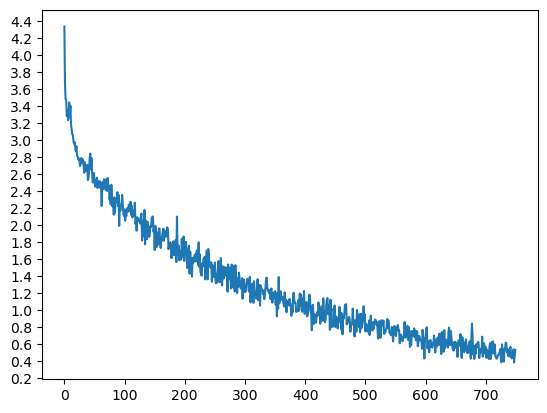

In [25]:
hidden_size = 256

# Initialize the encoder and decoder models
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train the models for 75000 iterations with a print frequency of 5000 iterations
trainIters(encoder2, decoder2, 75000, print_every=5000)

*Discussion of the `training time` and `loss` comparison between AttnDecoderRNN and DecoderRNN models will be in **5.3.1.4  Comparison Summary** section.*

#### Comparison of Translation Quality

In addition, to assess the translation quality of the two models, we will utilize objective Translation Evaluation Metrics such as `BLEU` (Bilingual Evaluation Understudy) score and `METEOR` (Metric for Evaluation of Translation with Explicit Ordering) score. These metrics allow us to quantitatively compare the generated translations against reference translations, mitigating subjective evaluations. The NLTK library will be employed to compute these metrics.

Here, we will use the modified `evaluateRandomly` function to generate a `references` list and a `candidates` list that will be used as inputs to calculate our `BLUE` score and `METEOR` score. Below are the definitions of references and candidates.

- `references` - a list of reference translations, which are the correct or desired translations of the given sentences. 
- `candidates` - consists of the generated translations produced by the model being evaluated. 

See below samples of random evaluations for both `ATTNDecoderRNN` and `DecoderRNN`.

**ATTNDecoderRNN evaluateRandomly**

In [151]:
ref_attn_list = [] # List to store attention weights of reference translations
cand_attn_list = []# List to store attention weights of candidate translations

# Evaluate the models 50 times and collect decoded words
for i in range(50):
    ref_attn, cand_attn = evaluateRandomly(encoder1, attn_decoder1)
    ref_attn_list.append(ref_attn)
    cand_attn_list.append(cand_attn)

> je ne suis pas supposee boire .
= i m not supposed to drink .
< i m not supposed to drink . <EOS>

> vous etes tres gentils .
= you re very nice .
< you re very nice . <EOS>

> j attends un client aujourd hui .
= i m expecting a customer today .
< i m expecting a new today . <EOS>

> nous n allons pas y arriver .
= we re not gonna make it .
< we re not going to it . <EOS>

> je ne blague pas .
= i m not kidding .
< i m not kidding . <EOS>

> je suis tres inquiet a ton sujet .
= i m very worried about you .
< i m very worried about you . <EOS>

> je suis populaire .
= i m popular .
< i m popular . <EOS>

> tu es incorrigible .
= you re incorrigible .
< you are incorrigible . <EOS>

> tu es en danger .
= you re in danger .
< you re in danger . <EOS>

> vous etes chanceux d avoir un travail .
= you re lucky that you have a job .
< you re lucky that you have a job . <EOS>

> je suis contente de t aider .
= i am glad to help you .
< i am glad to help you . <EOS>

> elles sont saoules .
= 

**DecoderRNN evaluateRandomly**

In [152]:
ref_dec_list = [] # List to store decoded words of reference translations
cand_dec_list = [] # List to store decoded words of candidate translations

# Evaluate the models 50 times and collect decoded words
for i in range(50):
    ref_dec, cand_dec = evaluateRandomly(encoder2, decoder2)
    ref_dec_list.append(ref_dec)
    cand_dec_list.append(cand_dec)

> c est un type tellement sympa !
= he s such a great guy .
< he s such a great boy . <EOS>

> tu es aussi grand que ma s ur .
= you are as tall as my sister .
< you are as tall as my sister . <EOS>

> je me rejouis que vous vous portiez bien .
= i m glad you re all right .
< i m glad you re all right . <EOS>

> il a environ mon age .
= he is about my age .
< he is about my age . <EOS>

> il est pauvre .
= he is poor .
< he is poor . <EOS>

> on te regarde .
= you re being watched .
< you re being watched . <EOS>

> tu n es pas si maline .
= you re not that smart .
< you re not that smart . <EOS>

> je vais etre marie .
= i m going to get married .
< i m going to get married . <EOS>

> il est tres jeune .
= he is very young .
< he is very young . <EOS>

> je pars en voyage d affaire .
= i m going on a business trip .
< i m going on a business of . . <EOS>

> vous etes invitee .
= you re invited .
< you re invited . <EOS>

> il est normalement chez lui le soir .
= he is generally at hom

This code block below prints the `BLUE` score and `METEOR` score for the two models. In this context, a higher score means better translation quality.

In [164]:
# Additional Imports for Translation Quality Scores
import nltk
from nltk.translate.meteor_score import meteor_score

bleu_score_attn_list = [] # List to store BLEU scores for AttnDecoderRNN
bleu_score_dec_list = [] # List to store BLEU scores for DecoderRNN
meteor_score_attn_list = [] # List to store METEOR scores for AttnDecoderRNN
meteor_score_dec_list = [] # List to store METEOR scores for DecoderRNN

# Calculate BLEU and METEOR scores for each translation pair
for i, j in enumerate(range(len(cand_dec_list))):
    # Calculate BLEU scores
    bleu_score_attn = nltk.translate.bleu_score.corpus_bleu(ref_attn_list[i],cand_attn_list[i])
    bleu_score_dec = nltk.translate.bleu_score.corpus_bleu(ref_dec_list[i], cand_dec_list[i])
    bleu_score_attn_list.append(bleu_score_attn)
    bleu_score_dec_list.append(bleu_score_dec)
    
    # Calculate METEOR scores
    meteor_score_attn = meteor_score(ref_attn_list[i],cand_attn_list[i])
    meteor_score_dec = meteor_score(ref_dec_list[i], cand_dec_list[i])
    meteor_score_attn_list.append(meteor_score_attn)
    meteor_score_dec_list.append(meteor_score_dec)

# Print average BLEU scores
print(f"BLEU Score AttnDecoderRNN: {np.mean(bleu_score_attn_list):.4f}")
print(f"BLEU Score DecoderRNN:     {np.mean(bleu_score_dec_list):.4f}")

# Compare BLEU scores and determine which model performs better
if bleu_score_attn > bleu_score_dec:
    print("AttnDecoderRNN has a higher BLEU score. It performs better.")
elif bleu_score_attn == bleu_score_dec:
    print("AttnDecoderRNN and DecoderRNN has the same BLEU score.")
else:
    print("DecoderRNN has a higher BLEU score. It performs better.")
    
print(f"\n")

# Print average METEOR scores
print(f"METEOR Score AttnDecoderRNN: {np.mean(meteor_score_attn_list):.4f}")
print(f"METEOR Score DecoderRNN:     {np.mean(meteor_score_dec_list):.4f}")

# Compare METEOR scores and determine which model performs better
if meteor_score_attn > meteor_score_dec:
    print("AttnDecoderRNN has a higher METEOR score.")
elif meteor_score_attn == meteor_score_dec:
    print("AttnDecoderRNN and DecoderRNN has the same METEOR score.")
else:
    print("DecoderRNN has a higher METEOR score.")


BLEU Score AttnDecoderRNN: 0.8284
BLEU Score DecoderRNN:     0.8356
DecoderRNN has a higher BLEU score. It performs better.


METEOR Score AttnDecoderRNN: 0.2632
METEOR Score DecoderRNN:     0.2632
AttnDecoderRNN and DecoderRNN has the same METEOR score.


*Discussion of the `translation quality` comparison between AttnDecoderRNN and DecoderRNN models will be in **5.3.1.4  Comparison Summary** section.*

#### Comparison of parameter count

Next, we need to calculate the number of parameters for both models. To get the total number of trainable parameters, we create a helper function `count_parameters` that takes a model as input and returns the total number of trainable parameters in that model.

In [35]:
def count_parameters(model):
    """
    Count the number of trainable parameters in a model.

    Args:
        model (torch.nn.Module): The model to count parameters for.

    Returns:
        int: The total number of trainable parameters in the model.
    """
    # Count the number of elements for trainable parameters in the model
    # by iterating over the parameters and summing the numel() for those
    # that require gradients.
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


We then calculate the number of parameters in the `encoder1` and `attn_decoder1` models using the count_parameters function. The total number of parameters in the model is obtained by adding the parameters of the encoder and decoder.

In [36]:
# Count the trainable parameters in the encoder
encoder_params = count_parameters(encoder1)

# Count the trainable parameters in the decoder
decoder_params = count_parameters(attn_decoder1)

# Count the total number of trainable parameters
total_params = encoder_params + decoder_params

# Print the number of trainable parameters in the encoder
print("Number of parameters in the encoder: {}".format(encoder_params))

# Print the number of trainable parameters in the decoder
print("Number of parameters in the decoder: {}".format(decoder_params))

# Print the total number of trainable parameters in the model
print("Total number of parameters in the model: {}".format(total_params))

Number of parameters in the encoder: 1507072
Number of parameters in the decoder: 1969149
Total number of parameters in the model: 3476221


We also do the same for `encoder2` and `decoder2`.

In [37]:
# trainable parameters in the encoder
encoder_params = count_parameters(encoder2)

# trainable parameters in the decoder
decoder_params = count_parameters(decoder2)

# the total number of trainable parameters
total_params = encoder_params + decoder_params

# Print the number of trainable parameters in the encoder
print("Number of parameters in the encoder: {}".format(encoder_params))

# Print the number of trainable parameters in the decoder
print("Number of parameters in the decoder: {}".format(decoder_params))

# Print the total number of trainable parameters in the model
print("Total number of parameters in the model: {}".format(total_params))

Number of parameters in the encoder: 1507072
Number of parameters in the decoder: 1832691
Total number of parameters in the model: 3339763


*Discussion of the `parameter count` comparison between AttnDecoderRNN and DecoderRNN models will be in **5.3.1.4  Comparison Summary** section.*

#### Comparison Summary

To facilitate comprehension and comparison, we have consolidated all the following information into a single table: `Number of Iterations`, `Loss`, `Training Time`, `Parameter Count`, `BLEU Score`, and `METEOR Score`. `See Table 1`.

For a more accurate comparison, both models were executed for 75,000 iterations, and here are the results:

**Loss** - In terms of loss, it was surprising that the AttnDecoderRNN model had a higher loss compared to the DecoderRNN model. Given that the AttnDecoderRNN model has a more complex architecture with the addition of the attention mechanism, one might expect it to perform better and have a lower loss. However, the opposite was observed in this case. It's important to note that a lower loss does not necessarily guarantee better quality translation.

**Training Time** - The DecoderRNN model took approximately 31 minutes and 34 seconds to train, while the AttnDecoderRNN model took approximately 42 minutes and 5 seconds. This indicates that the DecoderRNN model required less training time compared to the AttnDecoderRNN model. The difference in training time could be attributed to the additional attention mechanism present in the AttnDecoderRNN model, which introduces additional computational complexity and may require more time to train effectively.

**Parameter Count** - The DecoderRNN model had a parameter count of 3,339,763, while the AttnDecoderRNN model had a parameter count of 3,476,221. This indicates that the AttnDecoderRNN model had a slightly higher number of parameters compared to the DecoderRNN model. The parameter count difference indicates that the AttnDecoderRNN model may have a higher capacity to learn complex patterns and capture finer details in the translation task. This could potentially result in improved translation quality (but may not be the case), but it also introduces a higher risk of overfitting if the model is not properly regularized or if the dataset is insufficient.

**Translation Quality** - Comparing the translation quality scores, the DecoderRNN model achieved a higher BLEU score of 0.8356 compared to the AttnDecoderRNN model's score of 0.8284. However, both models obtained the same METEOR score of 0.2632. This implies that the DecoderRNN model performs better in terms of `lexical similarity` and `n-gram precision`, as indicated by the higher BLEU score. However, since both models have the same METEOR score, which considers additional factors such as `recall` and `alignment`, it suggests that they have `similar overall translation accuracy and fluency`. It is important to note that translation quality is a `multidimensional aspect`, and these scores provide a quantitative measure but may not capture all aspects of human-like translation performance.

<span style="font-size: 16px">
    <center><b>Table 1. Comparison of DecoderRNN and AttnDecoderRNN models.</b></center>
</span>
    
|<center>Variable Name</center>|<center>DecoderRNN</center>|<center>AttnDecoderRNN</center>|
|:-------------------------|:---------|:-----|
|**Number of Iterations**  |75,000   |75,000   |
|**Loss**                  |0.5003   |0.5614   |
|**Training Time**         |31m 34s  |42m 5s   |
|**Parameter Count**       |3,339,763|3,476,221|
|**BLEU Score**            |0.8356   |0.8284   |
|**METEOR Score**          |0.2632   |0.2632   |

### Implementing LSTM

6. In the **AttnDecoderRNN** model, swap out the **GRU** for an **LSTM**. Compare and contrast the two models in terms of loss, training time, parameter count, and quality of translation.

Next, our attention turns towards the `AttnDecoderRNN`, where we will substitute the `GRU` with an `LSTM` architecture. Since we have already obtained results for the GRU, our primary focus will be on implementing and evaluating the LSTM model. To accomplish this, we will begin by creating an `EncoderRNNLSTM` and an `AttnDecoderRNNLSTM`, which are variations of the encoder and attention decoder using the `LSTM` architecture.

Subsequently, we will proceed to define a customized training function to accommodate the new encoder-decoder architecture. Similarly, our evaluation function will also require modifications to adapt to the LSTM implementation. These adjustments will ensure the proper training and evaluation of our LSTM model.

In [115]:
class EncoderRNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, cell_size):
        """
        Initializes the EncoderRNNLSTM class with the specified input_size,
        hidden_size, and cell_size parameters.
        """
        super(EncoderRNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell_size = cell_size
    
        # Embedding layer to convert input tokens to dense vectors
        self.embedding = nn.Embedding(input_size, hidden_size)

        # LSTM layer for processing sequential input
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)

    def forward(self, input, hidden, cell):
        """
        Performs the forward pass of the encoder model. It takes input tokens,
        converts them into embeddings, and processes them through the LSTM layer.
        Returns the output, hidden state, and cell state.
        """
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)

        # Pass the embedded input through the LSTM layer
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        # Return the output and hidden state
        return output, hidden, cell

    def initHidden(self):
        """
        Initializes the hidden state with zeros.
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    def initCell(self):
        """
        Initializes the cell state with zeros.
        """
        return torch.zeros(1, 1, self.cell_size, device=device)
    

In [116]:
class AttnDecoderRNNLSTM(nn.Module):
    def __init__(self, hidden_size, cell_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
        Initializes the AttnDecoderRNNLSTM class with the specified hidden_size,
        cell_size, output_size, dropout_p, and max_length parameters.
        """
        super(AttnDecoderRNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.cell_size = cell_size
        
        # Embedding layer to convert output tokens to dense vectors
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Attention mechanism: linear layer to calculate attention weights
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # Linear layer to combine the attention output with the decoder output
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(self.dropout_p)

        # LSTM layer for processing sequential input
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)
        
        # Linear layer to map the hidden state to the output size
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs, cell):
        """
        Performs the forward pass of the decoder model with attention.
        It takes input tokens, converts them into embeddings, calculates
        the attention weights, applies attention to encoder outputs, and
        passes the combined output through the LSTM layer. Returns the output,
        hidden state, attention weights, and cell state.
        """
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Apply attention to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenate embedded input and attention output
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # Apply linear layer to combine the concatenated output
        output = self.attn_combine(output).unsqueeze(0)

        # Apply ReLU activation function to the combined output
        output = F.relu(output)
        
        # Pass the combined output through the LSTM layer
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        # Map the LSTM output to the output size using a linear layer
        output = F.log_softmax(self.out(output[0]), dim=1)

        # Return the output, hidden state, attention weights, and cell state
        return output, hidden, attn_weights, cell

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCell(self):
        # Initialize the cell state with zeros
        return torch.zeros(1, 1, self.cell_size, device=device)
    

In [201]:
# Teacher Forcing Ratio
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Performs one training iteration on the given input and target tensors
    using the encoder and decoder models.
    """
    encoder_hidden = encoder.initHidden()
    
    encoder_cell = encoder.initCell()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
     # Encoder forward pass
    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)   
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                decoder_hidden, encoder_outputs, decoder_cell)
                
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                decoder_hidden, encoder_outputs, decoder_cell)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [204]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Performs evaluation on a given sentence using the encoder
    and decoder models.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = None
        
        if type(encoder).__name__ == 'EncoderRNNLSTM':
            encoder_cell = encoder.initCell()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # Encoder forward pass
        for ei in range(input_length):
            if type(encoder).__name__ == 'EncoderRNNLSTM':
                encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)    
            else:
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        # Decoder forward pass
        for di in range(max_length):
            
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data

            elif type(decoder).__name__ == 'DecoderRNN':
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                
            else:
                decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                    decoder_hidden, encoder_outputs, decoder_cell)
                decoder_attentions[di] = decoder_attention.data
            
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        if type(decoder).__name__ == 'AttnDecoderRNN':
            return decoded_words, decoder_attentions[:di + 1]
        
        elif type(decoder).__name__ == 'DecoderRNN':
            return decoded_words, None

        else:
            return decoded_words, decoder_attentions[:di + 1]

#### LSTM Loss and Training TIme

Having established our helper functions for the `LSTM` implementation, we proceed to train the model for 75,000 iterations using the same input data. This approach enables us to make a comparative analysis of the performance between the two implementations on this particular dataset.

2m 56s (- 41m 7s) (5000 6%) 3.0573
5m 53s (- 38m 15s) (10000 13%) 2.4627
8m 53s (- 35m 35s) (15000 20%) 2.1845
11m 49s (- 32m 31s) (20000 26%) 2.0104
14m 48s (- 29m 37s) (25000 33%) 1.8348
17m 37s (- 26m 26s) (30000 40%) 1.6611
20m 28s (- 23m 24s) (35000 46%) 1.5387
23m 23s (- 20m 28s) (40000 53%) 1.4096
26m 21s (- 17m 34s) (45000 60%) 1.3211
29m 8s (- 14m 34s) (50000 66%) 1.2063
32m 11s (- 11m 42s) (55000 73%) 1.0788
35m 0s (- 8m 45s) (60000 80%) 1.0188
37m 54s (- 5m 49s) (65000 86%) 0.9544
40m 52s (- 2m 55s) (70000 93%) 0.8780
43m 56s (- 0m 0s) (75000 100%) 0.8065


<Figure size 640x480 with 0 Axes>

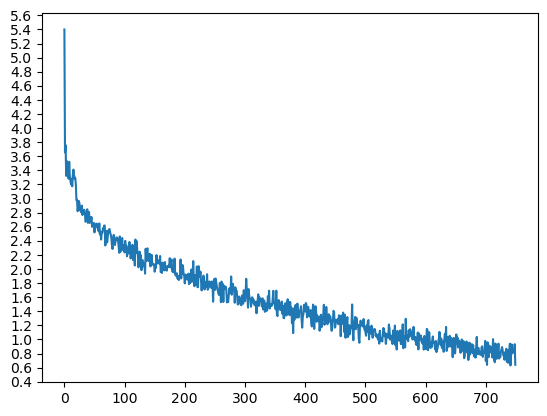

In [121]:
hidden_size = 256 # Hidden size of the LSTM layers
cell_size = 256 # Cell size of the LSTM layers

# Initialize the EncoderRNNLSTM with the specified hidden size and cell size
encoder_lstm = EncoderRNNLSTM(input_lang.n_words, hidden_size, cell_size).to(device)

# Initialize the AttnDecoderRNNLSTM with the specified hidden size, cell size, output size,
# dropout rate, and maximum length
attn_decoder_lstm = AttnDecoderRNNLSTM(hidden_size, cell_size, output_lang.n_words, dropout_p=0.1).to(device)

# Train the encoder_lstm and attn_decoder_lstm models for a total of 75000 iterations,
# printing the progress every 5000 iterations
trainIters(encoder_lstm, attn_decoder_lstm, 75000, print_every=5000)

#### LSTM Translation Quality

Now that we have obtained the training time and training loss for both implementations, we can proceed to examine additional metrics such as translation quality and parameter count. These metrics will provide us with further insights for comparing the GRU and LSTM implementations.

In [167]:
ref_lstm_list = [] # List to store reference sentences generated by the encoder-decoder LSTM model
cand_lstm_list = [] # List to store candidate sentences generated by the encoder-decoder LSTM model

# Generate reference and candidate sentences for 50 random examples
for i in range(50):
    ref_lstm, cand_lstm = evaluateRandomly(encoder_lstm, attn_decoder_lstm)
    ref_lstm_list.append(ref_lstm)
    cand_lstm_list.append(cand_lstm)

> je suis certain .
= i m certain .
< i m sure . <EOS>

> elles sont toutes en train de nous regarder .
= they re all watching us .
< they re all us . <EOS>

> il commence a avoir les jetons .
= he s getting cold feet .
< he s getting up . <EOS>

> je ne me dispute pas .
= i m not arguing .
< i m not feeling . <EOS>

> cela fait vingt ans qu il enseigne .
= he s been teaching for years .
< he s been teaching for years . <EOS>

> vous etes bon menteur .
= you re a good liar .
< you re a good liar . <EOS>

> nous sommes tous uniques .
= we re all unique .
< we re all set . <EOS>

> il n est pas americain .
= he isn t an american .
< he is not an american . <EOS>

> vous etes bavards .
= you re talkative .
< you re big . <EOS>

> tu n es pas indispensable .
= you re replaceable .
< you re not bruised . <EOS>

> j ai termine .
= i m finished .
< i m finished . <EOS>

> il est americain .
= he is an american .
< he is an american . <EOS>

> vous ne m aidez pas .
= you re not helping me .
< 

In [174]:
bleu_score_lstm_list = [] # List to store BLEU scores for LSTM model
meteor_score_lstm_list = [] # List to store METEOR scores for LSTM model

# Compute BLEU and METEOR scores for each reference-candidate pair
for i, j in enumerate(range(len(ref_lstm_list))):
    bleu_score_lstm = nltk.translate.bleu_score.corpus_bleu(ref_lstm, cand_lstm)
    meteor_score_lstm = meteor_score(ref_lstm, cand_lstm)
    bleu_score_lstm_list.append(bleu_score_lstm)
    meteor_score_lstm_list.append(meteor_score_lstm)

# Print average BLEU and METEOR scores for LSTM model
print(f"BLEU Score LSTM:     {np.mean(bleu_score_lstm_list):.4f}")
print(f"METEOR Score LSTM: {np.mean(meteor_score_lstm_list):.4f}")


BLEU Score LSTM:     0.7979
METEOR Score LSTM: 0.2632


#### LSTM Parameter Count

In [126]:
# Count parameters in the encoder LSTM
encoder_params = count_parameters(encoder_lstm)

# Count parameters in the attention decoder LSTM
decoder_params = count_parameters(attn_decoder_lstm)

# Calculate total number of parameters
total_params = encoder_params + decoder_params

# Print the number of trainable parameters in the encoder
print("Number of parameters in the encoder: {}".format(encoder_params))

# Print the number of trainable parameters in the decoder
print("Number of parameters in the decoder: {}".format(decoder_params))

# Print the total number of trainable parameters in the model
print("Total number of parameters in the model: {}".format(total_params))

Number of parameters in the encoder: 1638656
Number of parameters in the decoder: 2100733
Total number of parameters in the model: 3739389


#### Comparison Summary

Now that we have all the necessary information for comparing the `GRU` implementation and `LSTM` implementation, we can consolidate the data into a single table for a comprehensive analysis. Additionally, we will include the regular DecoderRNN in the table for reference. `See Table 2`.

**Loss:** The AttnDecoderRNN with GRU had a lower loss compared to the AttnDecoderRNN with LSTM. This indicates that the GRU implementation achieved better performance in terms of minimizing training loss. This suggests that the GRU implementation was better at capturing and learning the patterns in the training data, resulting in a closer approximation of the target translations.

**Training Time:** The training time for the AttnDecoderRNN with GRU was 42 minutes and 5 seconds, while the AttnDecoderRNN with LSTM took 43 minutes and 56 seconds to train. Therefore, the GRU implementation required less time for training compared to the LSTM implementation. However, the slight difference in training time between the AttnDecoderRNN with GRU and LSTM (approximately 1 minute) is relatively negligible. It indicates that both implementations have similar training efficiency and can be trained within a reasonable timeframe.

**Parameter Count:** The AttnDecoderRNN with GRU had a parameter count of 3,476,221, while the AttnDecoderRNN with LSTM had a parameter count of 3,739,389. The GRU implementation had a slightly lower parameter count, indicating a relatively simpler model architecture. A lower parameter count can have advantages such as reduced memory requirements and potentially faster inference time.

**Translation Quality:** The AttnDecoderRNN with LSTM achieved a lower BLEU score of 0.7979 compared to the BLEU score of 0.8284 for the AttnDecoderRNN with GRU. This indicates that the LSTM implementation produced translations that were farther from the reference translations, suggesting a lower quality of translation. However, both implementations had the same METEOR score of 0.2632, indicating that they had similar performance in terms of recall and alignment, and suggesting that they have similar overall translation accuracy and fluency.

<span style="font-size: 16px">
    <center><b>Table 2. Comparison of the GRU and LSTM models.</b></center>
</span>
    
|<center>Variable Name</center>|<center>DecoderRNN</center>|<center>AttnDecoderRNN GRU</center>|<center>AttnDecoderRNN LSTM</center>|
|:-------------------------|:--------|:--------|:--------|
|**Number of Iterations**  |75,000   |75,000   |75,000   |
|**Loss**                  |0.5003   |0.5614   |0.8065   |
|**Training Time**         |31m 34s  |42m 5s   |43m 56s  |
|**Parameter Count**       |3,339,763|3,476,221|3,739,389|
|**BLEU Score**            |0.8356   |0.8284   |0.7979   |
|**METEOR Score**          |0.2632   |0.2632   |0.2632   |

# Choosing the Best Model

Based on our evaluation of 50 trials, the DecoderRNN model emerges as the top performer for the following reasons:

1. It achieved the lowest loss among all models.
2. It exhibited the shortest training time compared to other models.
3. It attained the highest BLEU score, indicating superior translation quality.

Now, let's proceed to translate a few samples and compare the results with Google Translate.

In [176]:
# Evaluate Randomly
evaluateRandomly(encoder2, decoder2)

> elle est plus jeune que lui .
= she s younger than him .
< she s older than him . <EOS>

> il quittera chicago demain .
= he is leaving chicago tomorrow .
< he is leaving chicago tomorrow . <EOS>

> je cherche un emploi .
= i m looking for a job .
< i m looking for a job . <EOS>

> nous avons toutes faim .
= we re all hungry .
< we re all hungry . <EOS>

> nous y sommes tous ensemble .
= we re all in this together .
< we re all together this together . <EOS>

> elle a deux ans de moins que moi .
= she is two years younger than me .
< she is two years older than i am . <EOS>

> je ne suis pas ta bonne .
= i m not your maid .
< i m not your maid . <EOS>

> je suis vraiment content .
= i m really happy .
< i m really happy . <EOS>

> elle est toujours aussi pauvre .
= she is as poor as ever .
< she is still as up as a bee . <EOS>

> je ne suis pas facilement impressionne .
= i m not easily impressed .
< i m not easily impressed . <EOS>



([['she s younger than him .'],
  ['he is leaving chicago tomorrow .'],
  ['i m looking for a job .'],
  ['we re all hungry .'],
  ['we re all in this together .'],
  ['she is two years younger than me .'],
  ['i m not your maid .'],
  ['i m really happy .'],
  ['she is as poor as ever .'],
  ['i m not easily impressed .']],
 ['she s older than him .',
  'he is leaving chicago tomorrow .',
  'i m looking for a job .',
  'we re all hungry .',
  'we re all together this together .',
  'she is two years older than i am .',
  'i m not your maid .',
  'i m really happy .',
  'she is still as up as a bee .',
  'i m not easily impressed .'])

Among the 10 randomly selected sentences, Google Translate emerged as the top performer in French-English translation. It outperformed the DecoderRNN GRU model in four translations, showed only a slight discrepancy in one, and achieved tie scores in the remaining five translations. The details are summarized below.

**Insights:**

1. In the four instances where Google Translate won, the DecoderRNN GRU model failed to accurately translate the sentence.
2. The only victory for DecoderRNN GRU was due to a tense error in Google Translate. However, Google Translate still managed to capture the overall meaning of the sentence.
3. In all five tie cases, both DecoderRNN GRU and Google Translate produced the same translation output.

**Conclusion:**

Google Translate performed better in this evaluation due to several reasons:

1. **Large-scale Training Data:** Google Translate has access to vast amounts of training data collected from various sources, including professional translations and bilingual documents. This extensive training data allows it to learn patterns and improve translation quality.
2. **Neural Machine Translation (NMT) Architecture:** Google Translate employs advanced neural machine translation techniques, including deep learning models such as recurrent neural networks (RNNs) and transformer models. These architectures have demonstrated superior performance in capturing complex language structures and producing high-quality translations.
3. **Continuous Improvement:** Google Translate benefits from continuous updates and improvements by a team of language experts and machine learning researchers. Regular updates and refinements to the translation models help enhance accuracy and address common translation challenges.
4. **Multilingual Approach:** Google Translate supports translation between a wide range of languages, which enables cross-lingual learning. By leveraging knowledge and patterns from various language pairs, the translation quality can be further improved.

It's important to note that Google Translate is a sophisticated machine translation system developed by a dedicated team of experts. It has undergone extensive optimization and refinement over the years, resulting in its high performance and widespread usage.

*Please refer to Table 3 for the specific translations and outcomes.*

<span style="font-size: 16px">
    <center><b>Table 3. Comparison of the Best Model Translation vs. Google Translate</b></center>
</span>
    
|<center>French</center>|<center>Correct Translation</center>|<center>DecoderRNN GRU</center>|<center>Google Translate</center>|<center>Winner</center>|
|:-----------------------------------------|:--------|:--------|:--------|:--------|
|**elle est plus jeune que lui**           |she s younger than him          |she s older than him            |she is younger than him|Google Translate
|**il quittera chicago demain**            |he is leaving chicago tomorrow  |he is leaving chicago tomorrow  |he will leave chicago tomorrow|DeciderRNN GRU
|**je cherche un emploi**                  |i m looking for a job           |i m looking for a job           |I am looking for a job|-
|**nous avons toutes faim**                |we re all hungry                |we re all hungry                |we are all hungry|-
|**nous y sommes tous ensemble**           |we re all in this together      |we re all together this together|we are all here together|Google Translate
|**elle a deux ans de moins que moi**      |she is two years younger than me|she is two years older than i am|she is two years younger than me|Google Translate
|**je ne suis pas ta bonne**               |i m not your maid               |i m not your maid               |i'm not your maid|-
|**je suis vraiment content**              |i m really happy                |i m really happy                |I am really happy|-
|**elle est toujours aussi pauvre**        |she is as poor as ever          |she is still as up as a bee     |she is still so poor|Google Translate
|**je ne suis pas facilement impressionne**|i m not easily impressed        |i m not easily impressed        |I'm not easily impressed|-

# Visualizing Attention

## Attention Matrix for AttnDecoderRNN GRU

Finally, we visualize the attention weights as a matrix plot. This allows us to observe the attention distribution over the input and output sequence, highlighting the alignment between the words in the input and the generated output.

By plotting the attention matrix, we can identify which words in the input sentence the model attends to more heavily when generating the output sequence. This visualization provides insights into how the model focuses its attention during the translation process.

However, it is worth noting that the viewing experience with this visualization is not optimal, as the x and y axes only show the indices of the words instead of the actual words themselves.

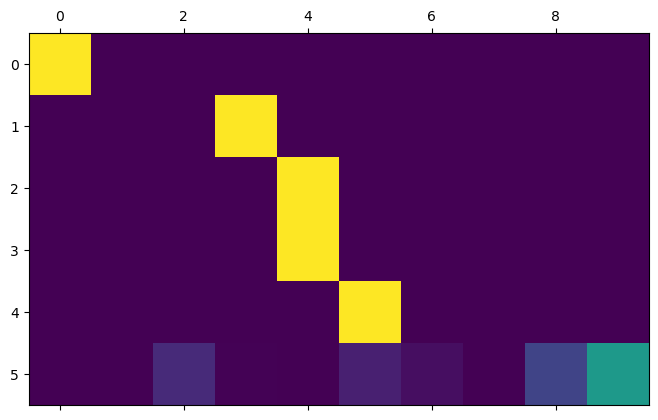

In [178]:
# Evaluate the input sentence using the encoder and decoder models
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")

# Visualize the attention weights as a matrix plot
plt.matshow(attentions.numpy());

To enhance the viewing experience, we have created functions that allow us to display the attention weights with the axes representing the actual words instead of their indices. This improves the interpretability of the visualization.

By utilizing these functions, we can visualize the attention distribution over the input and output sequences, providing a clear understanding of how the model aligns the words in the input with the generated output. This insight helps us gain a deeper understanding of the model's attention mechanism during the translation process.

With the improved visualization, we can easily identify which words in the input sentence the model focuses on more prominently when generating the output sequence. This visualization greatly facilitates the analysis and interpretation of the model's behavior.

In [198]:
def showAttention(input_sentence, output_words, attentions):
    """
    Display the attention weights as a matrix plot.

    Args:
        input_sentence (str): Input sentence.
        output_words (list): List of output words.
        attentions (Tensor): Attention weights.

    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    """
    Evaluate the input sentence using the encoder and decoder models,
    and display the attention weights.

    Args:
        input_sentence (str): Input sentence.
        encoder (EncoderRNN): Encoder model.
        decoder (DecoderRNN or AttnDecoderRNN): Decoder model.

    """
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    if attentions is not None:
        showAttention(input_sentence, output_words, attentions)



By examining the attention plot, we can observe the attention distribution and understand how the model attends to different words in the input when generating the output. This information helps us gain insights into the model's attention mechanism and how it captures the relationships between words during translation.

Below are four (4) sample evaluations:

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


/tmp/ipykernel_173/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_173/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


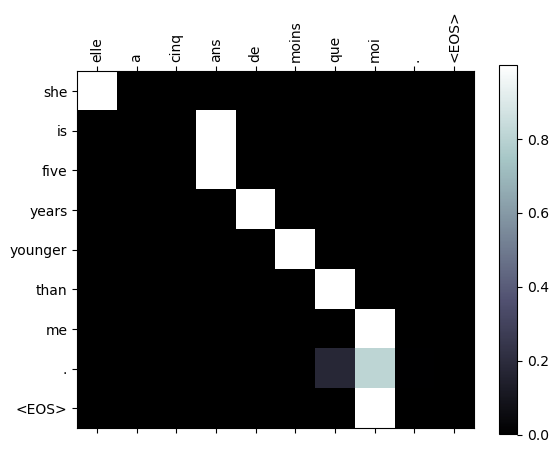

input = elle est trop petit .
output = she s too loud . <EOS>


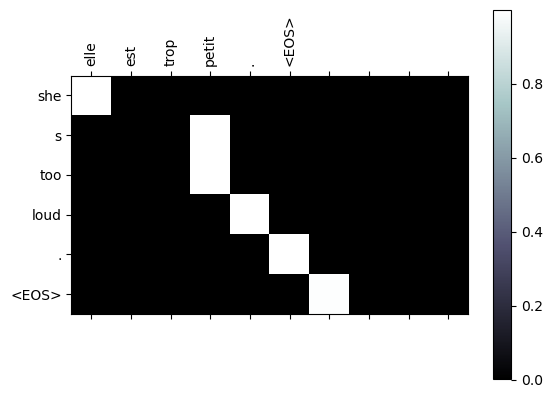

input = je ne crains pas de mourir .
output = i m afraid to die . <EOS>


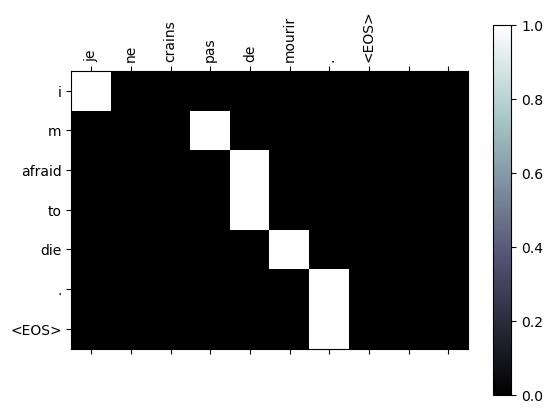

input = c est un jeune directeur plein de talent .
output = he s a talented young talented . <EOS>


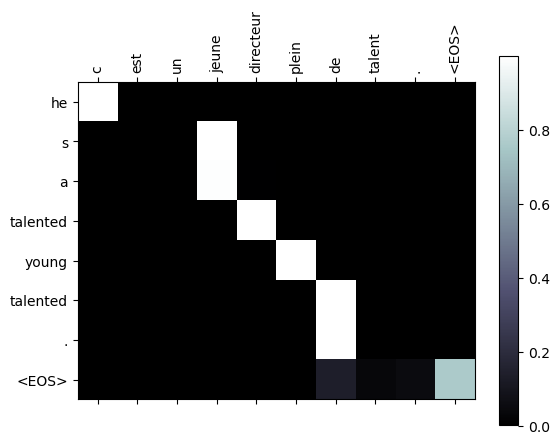

In [205]:
# Evaluate and show attention for the sentence "elle a cinq ans de moins que moi ." (she is five years younger than me)
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder1, attn_decoder1)

# Evaluate and show attention for the sentence "elle est trop petit ." (she is too small)
evaluateAndShowAttention("elle est trop petit .", encoder1, attn_decoder1)

# Evaluate and show attention for the sentence "je ne crains pas de mourir ." (I am not afraid to die)
evaluateAndShowAttention("je ne crains pas de mourir .", encoder1, attn_decoder1)

# Evaluate and show attention for the sentence "c est un jeune directeur plein de talent ." (he is a young talented director)
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder1, attn_decoder1)

## Attention Matrix for AttnDecoderRNN LSTM

We do the same for the LSTM implementation.

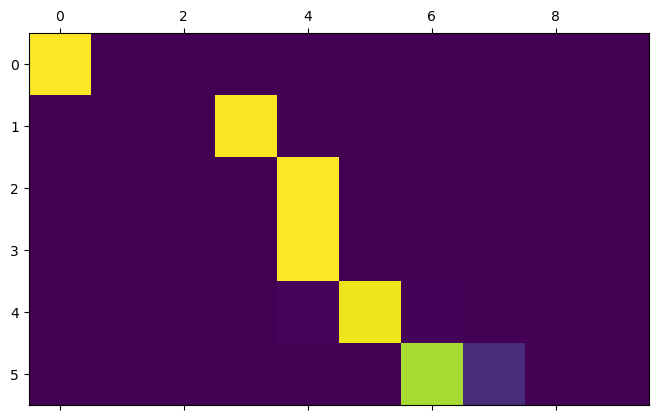

In [209]:
# Evaluate the input sentence using the encoder and decoder models
output_words, attentions = evaluate(
    encoder_lstm, attn_decoder_lstm, "je suis trop froid .")

# Visualize the attention weights as a matrix plot
plt.matshow(attentions.numpy());

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


/tmp/ipykernel_173/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_173/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


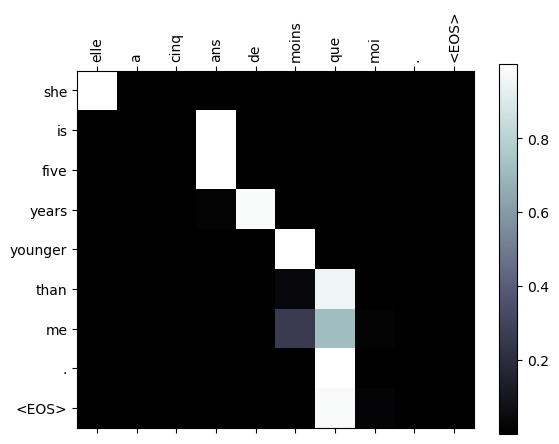

input = elle est trop petit .
output = she is too loud . <EOS>


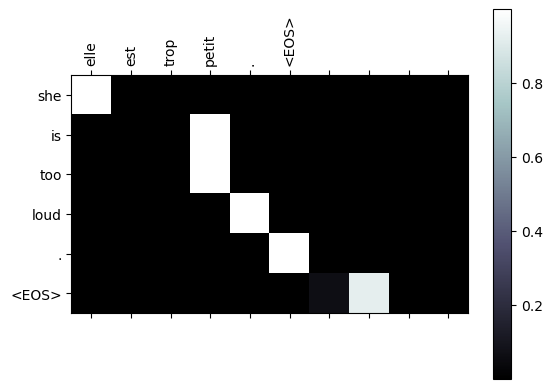

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


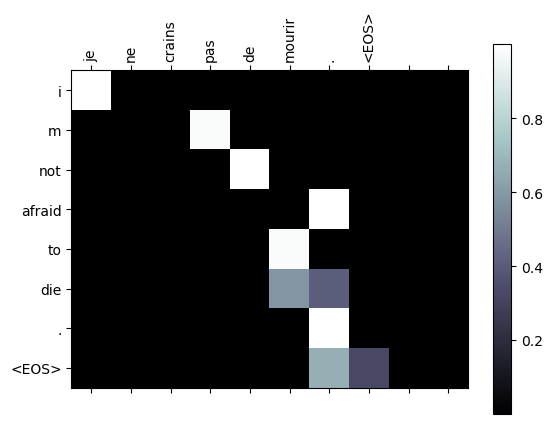

input = c est un jeune directeur plein de talent .
output = he is very young talented . <EOS>


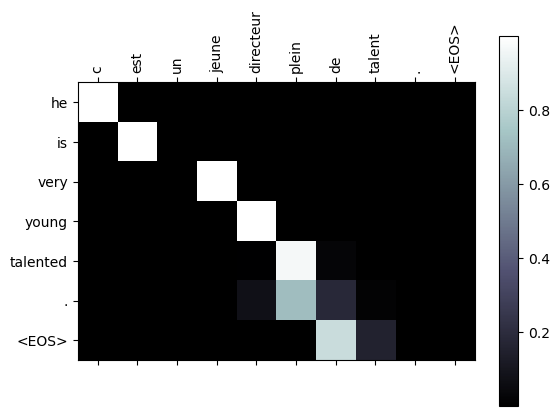

In [206]:
# Evaluate and show attention for the sentence "elle a cinq ans de moins que moi ." (she is five years younger than me)
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder_lstm, attn_decoder_lstm)

# Evaluate and show attention for the sentence "elle est trop petit ." (she is too small)
evaluateAndShowAttention("elle est trop petit .", encoder_lstm, attn_decoder_lstm)

# Evaluate and show attention for the sentence "je ne crains pas de mourir ." (I am not afraid to die)
evaluateAndShowAttention("je ne crains pas de mourir .", encoder_lstm, attn_decoder_lstm)

# Evaluate and show attention for the sentence "c est un jeune directeur plein de talent ." (he is a young talented director)
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder_lstm, attn_decoder_lstm)

# Generative AI Documentation

In this assignment, ChatGPT was utilized to accomplish the following tasks:

**Explanations/Ideation:**

1. **Comparing GRU and LSTM:** Explained the differences between the GRU and LSTM recurrent neural network architectures.
2. **Attention Mechanism:** Provided insights and explanations regarding the attention mechanism, its purpose, and how it improves sequence-to-sequence models.
3. **Seq2Seq Model:** Helped you brainstorm ideas about the seq2seq model, its components, and its applications beyond machine translation.
4. **Decoder and Encoder:** Provided guidance in understanding the decoder and encoder components, their roles in the seq2seq model, and potential modifications or variations.
5. **Implications:** Contributed to your analysis of the implications of different factors on the model's performance, such as loss functions, training time, translation quality, and parameter count.
6. **Attention Plot Interpretation:** Assisted in generating ideas about interpreting attention plots, discussing the alignment between input and output sequences, and uncovering patterns or insights.
7. **Validation of Analysis and Interpretations**: Helped validate and refine analysis and interpretations by providing alternative viewpoints and suggesting further experiments or evaluations.
8. **Imported Libraries:** Explained the imported libraries in this notebook.


**Code:**

1. **LSTM Implementation:** Aided in generating a code for the LSTM model.
2. **Quantitative Measures for Translation Quality:** Incorporated quantitative metrics to evaluate the translation quality, such as BLEU score and METEOR score.
3. **Docstring:** Added docstrings to functions, providing descriptions of their purpose, arguments, and return values.
4. **One-liner Comments:** Inserted concise comments within the code to provide brief explanations of specific functionalities or operations.
5. **Parameter Count Computation:** Aided in generating a code for calculating the total number of parameters in the model by counting the parameters of the encoder and decoder components.


**Proofreading:**

1. **Grammatical Corrections:** Made grammatical corrections and refined the language used in the assignment.
2. **Notebook Flow:** Ensured clarity and coherence in the explanations and descriptions provided.

# References

**Seq2seq Models:**

Loye, G. (2019). Gated Recurrent Unit (GRU) With PyTorch. FloydHub. Retrived from https://blog.floydhub.com/gru-with-pytorch/

Bahrami, E. (2019). Implementation of LSTM and GRU cells for PyTorch. Github. Retrieved from https://github.com/emadRad/lstm-gru-pytorch

Trevett, B. (2021). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. Github. Retrieved from https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb

Jana, A. (2020). Machine Translation using Recurrent Neural Network and PyTorch. A Developer Diary. Retrieved from https://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-recurrent-neural-network-pytorch/

Kelly, J. (2021). PyTorch Tutorial - RNN & LSTM & GRU - Recurrent Neural Nets. Morioh. Retrieved from https://morioh.com/p/8cbd4d8604eb

</br>

**Seq2seq Models With Attention:**

Allamar, J. (2018). Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention). GitHub Pages. Retrieved from https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/


Robertson, S. (n.d.). NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION. PyTorch Tutorials. Retrived from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

</br>

**Original Papers:**

Cho et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. https://arxiv.org/abs/1406.1078

Chung et al. (2014). Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling. https://arxiv.org/abs/1412.3555

Hochreiter, S., Schmidhuber, J. (1997). Long Short-term Memory. Neural computation. 9. 1735-80. 10.1162/neco.1997.9.8.1735.
https://www.bioinf.jku.at/publications/older/2604.pdf